In [1]:
from os.path import join
from datetime import datetime

import numpy as np
import pandas as pd
import pymagicc
from pymagicc import rcp26
from pymagicc.io import MAGICCData
from pymagicc.definitions import MAGICC7_EMISSIONS_UNITS
from pymagicc.definitions import convert_magicc7_to_openscm_variables

from openscm.core import Core, ParameterSet
from openscm.units import unit_registry
from openscm.internal import Adapter

ImportError: cannot import name 'OpenSCMDataFrame' from 'openscm.highlevel' (/Users/zebedeenicholls/Documents/AGCEC/MCastle/openscm/openscm/highlevel.py)

In [ ]:
import matplotlib
%matplotlib inline

In [ ]:
DATA_PATH = join("..", "data", "rcps")
# make internal
ONE_YEAR = 1*unit_registry("yr").to("s").magnitude

In [ ]:
rcp26.head()

In [5]:
def convert_datetime_to_openscm_time(dt_in):
    openscm_reference_time = datetime(1970, 1, 1, 0, 0, 0)
    return (dt_in - openscm_reference_time).total_seconds()

In [6]:
# TODO: make conversion to seconds internal
magicc = Core(
    "MAGICC6", 
    convert_datetime_to_openscm_time(datetime(1765, 1, 1, 0, 0, 0)),
    convert_datetime_to_openscm_time(datetime(2499, 12, 31, 23, 59, 59)),
)

In [7]:
# TODO: put something like this in gap between high and low level interfaces
def convert_pymagicc_df_to_parameter_set(pymagicc_df):
    # make internal
    ONE_YEAR = 1*unit_registry("yr").to("s").magnitude
    
    parameter_set = ParameterSet()
    for (variable, region), df in pymagicc_df.groupby(["variable", "region"]):
        df = df.sort_values("time")
        variable_openscm = tuple(variable.split("|"))  # TODO: remove hard coding
        region_openscm = tuple(region.split("|"))
        unit = df.unit.unique()
        assert len(unit) == 1, "emissions timeseries should all be in one unit"  # TODO: remove this restriction
        unit = unit[0]
        syr = df.time.min()
        assert syr == 1765, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        eyr = df.time.max()
        assert eyr == 2500, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        assert len(df) == 736, "have not considered cases other than the RCPs read in by pymagicc yet"  # TODO: remove this restriction
        tstep = ONE_YEAR  # having passed all above, can safely assume this [TODO: remove this assumption]

        emms_view = parameter_set.get_writable_timeseries_view(
            variable_openscm,
            region_openscm,
            unit,
            convert_datetime_to_openscm_time(datetime(syr, 1, 1, 0, 0, 0)),
            ONE_YEAR
        )
        emms_view.set_series(df["value"].values)

    return parameter_set

In [8]:
class MAGICC6(Adapter):
    def __init__(self, parameters: ParameterSet):
        self.parameters = parameters
        self.magicc = pymagicc.MAGICC6()

    def initialize(self) -> None:
        """
        Initialize the model.
        """
        # TODO: make this robust to not using temporary magicc setups
        self.magicc.create_copy()

    def run(self) -> None:
        """
        Run the model over the full time range.
        """
        # in here is where all the switches about conc driven, emissions driven
        # etc. would be processed
        drivers = self.get_pymagicc_df()
        results = self.magicc.run(drivers)
        
        return results
    
    def get_pymagicc_df(self) -> pymagicc.io.MAGICCData:
        ONE_YEAR = 1*unit_registry("yr").to("s").magnitude  # make internally available
        scen_file_emissions_units = MAGICC7_EMISSIONS_UNITS[
            MAGICC7_EMISSIONS_UNITS["part_of_scenfile_with_emissions_code_1"]
        ]  # can only convert to SCEN file for now
        region = ("World", )  # TODO: remove hard coding
        stime = convert_datetime_to_openscm_time(datetime(1765, 1, 1, 0, 0, 0))  # TODO: remove hard coding

        emms_df = []
        for (variable, unit), df in scen_file_emissions_units.groupby(["magicc_variable", "emissions_unit"]):
            variable_well_defined = "{}_EMIS".format(variable)
            openscm_variable = convert_magicc7_to_openscm_variables(variable_well_defined)

            emms_view = self.parameters.get_timeseries_view(
                tuple(openscm_variable.split("|")),  # TODO: remove hard coding
                region,
                unit,
                stime,
                ONE_YEAR,
            )

            values = emms_view.get_series()
            assert len(values) == 736
            time = np.arange(1765, 2501)  # TODO: remove hard coding
            emms_df.append(pd.DataFrame({
                "variable": openscm_variable,
                "todo": "SET",
                "unit": unit,
                "region": "|".join(region),  # TODO: remove hard coding
                "time": time,  
                "value": values,
            }))

        emms_df = pd.concat(emms_df)
        mdata = MAGICCData()
        mdata.df = emms_df  # TODO: make this less rubbish
        
        return mdata
        
    def step(self) -> None:
        """
        Do a single time step.
        """
        raise NotImplementedError

In [9]:
m = MAGICC6(convert_pymagicc_df_to_parameter_set(rcp26))
m.initialize()

In [10]:
results = m.run()

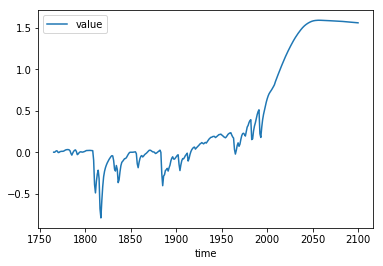

In [11]:
results.df[
    (results.df["variable"] == "Surface Temperature")
    & (results.df["region"] == "World")
].plot(x="time", y="value")

In [12]:
# TODO: move into highlevel
# TODO: add caching flag

# order to move to:
# - for model in models
#     - spin up model
#     - for scenario in scenarios
#        - setup scenario
#        - for config in configs
#            - run config
#            - append output to results
# - concatenate results and return
def run(drivers, model_configurations):
    assert isinstance(model_configurations, dict), "model_configurations must be a dictionary"
    results = []
    for model, configurations in model_configurations.items():
        print("running {}\n".format(model))
        runner = Core(
            model, 
            convert_datetime_to_openscm_time(datetime(1765, 1, 1, 0, 0, 0)),  # TODO: remove hard coding
            convert_datetime_to_openscm_time(datetime(2499, 12, 31, 23, 59, 59)),  # TODO: remove hard coding
        )
        runner.initialize()
        for scenario, sdf in drivers.groupby(["scenario"]):
            parameter_set_scenario = convert_pymagicc_df_to_parameter_set(sdf)
            runner.setup_scenario(parameter_set_scenario)
            for config in configurations:
                parameter_set_config = convert_dict_to_parameter_set(config)
                config_results = runner.run(parameter_set_config)
                results.append(convert_parameter_set_to_openscmdf(config_results))
                # TODO: get parameters out here too
            
    return pd.concat(results)

In [13]:
run(rcp26, {"MAGICC6": None})

running MAGICC6



AttributeError: 'Core' object has no attribute 'initialize'